<a href="https://colab.research.google.com/github/angelinemarym/X-Sentiment-Analysis/blob/main/NLP_Final_Project_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter (X) Sentiment Analysis

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import re # a module that handles regular expressions

# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

# NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data Prepraration

In [ ]:
# Mount data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data inside the .csv files do not have name for each column, so we initialize the column names
columns = ['ID', 'Entity', 'Sentiment', 'Content']

# Read the data (Change the file directory according to your .csv file location)
df = pd.read_csv("/content/gdrive/MyDrive/NLP/Twitter Sentiment Analysis/twitter_training.csv",
                        names = columns # to set the column names
                       )

In [ ]:
# Check the first 5 data in the dataset
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df.size

298728

In [ ]:
# Check for null values in the dataset
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [ ]:
# Drop null values
df.dropna(subset = ['Content'], inplace = True)

In [ ]:
# Replace 'Irrelevant' values into 'Neutral' in the 'Sentiment' column
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## Exploratory Data Analysis

### Sentiment Distribution

In [ ]:
# Count the amount of data for each sentiment group
sentiment_counts = df['Sentiment'].value_counts().sort_index()

# Set the labels & colors for sentiment groups
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_colors = ['red', 'blue', 'green']

# Create pie graph to visualize the sentiment groups composition
sentiment_pie_fig = go.Figure(
    data = [go.Pie(
        labels = sentiment_counts.index,
        values = sentiment_counts.values,
        textinfo = 'percent+value+label',
        marker_colors = sentiment_colors,
        textposition = 'auto',
        hole = .3
    )]
)

sentiment_pie_fig.update_layout(
    title_text='Sentiment Distribution',
    template='plotly_white'
)

sentiment_pie_fig.show()

There are 30.2% of negative sentiment texts about entity (22,358 data), 41.9% of neutral sentiment texts about entity (30,983 data), and 27.9% of positive sentiment texts about entity (20,655 data),

### Entity Distribution

In [ ]:
# Check & count the top 10 entities
top10_entity_counts = df['Entity'].value_counts().sort_values(ascending = False)[:10]

# Create a bar plot to visualize the top 10 entities counts
entity_distribution_bar_fig = px.bar(
    x = top10_entity_counts.index,
    y = top10_entity_counts.values,
    color = top10_entity_counts.values,
    text= top10_entity_counts.values,
    color_continuous_scale='Greens'
)

entity_distribution_bar_fig.update_layout(
    title_text='Top 10 X Entity Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Entity',
    ),
    yaxis=dict(
        title='Number of Posts in X',
    )
)

entity_distribution_bar_fig.show()

The top 3 most distributed entities in the dataset are **MaddenNFL**, **LeagueOfLegends**, and **CallOfDuty**

### Sentiment Distribution in Top 3 Entities

In [ ]:
# Count the amount of sentiment group data for the top 3 entities
top3_entity_df = df['Entity'].value_counts().sort_values(ascending=False)[:3]
top3_entity = top3_entity_df.index.tolist()

sentiment_by_entity = df.loc[df['Entity'].isin(top3_entity)].groupby('Entity')['Sentiment'].value_counts().sort_index()

# Set the labels & colors for sentiment groups
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_colors = ['red', 'blue', 'green']

n_row = 1
n_col = 3

# Create pie graph to visualize the sentiment groups composition
sentiment_by_entity_pie_fig = make_subplots(
    rows = n_row,
    cols = n_col,
    specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], # to specify the type of subplots
    subplot_titles = top3_entity
  )

for i, col in enumerate(top3_entity):
  sentiment_by_entity_pie_fig.add_trace(
      go.Pie(
          labels = sentiment_labels,
          values = sentiment_by_entity[col].values,
          textinfo = 'percent+value+label',
          marker_colors = sentiment_colors,
          textposition = 'auto',
          name = col
      ),
      row = int(i/n_col) + 1,
      col = int(i%n_col) + 1
  )

sentiment_by_entity_pie_fig.show()

## NLP Preprocessing

The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
* Replacing Usernames: Replace @Usernames with word "USER". (eg: "@XXXX" to "USER")
* Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
* Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

### Function Definition

In [ ]:
def preprocess(textdata):
  processed_text = []

  # Create Lemmatizer and Stemmer.
  word_lemm = WordNetLemmatizer()
  stopword_list = stopwords.words('english')

  # Defining regex patterns.
  url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  user_pattern       = '@[^\s]+'
  alpha_pattern      = "[^a-zA-Z0-9]"
  sequence_pattern   = r"(.)\1\1+"
  seq_replace_pattern = r"\1\1"

  for tweet in textdata:
    tweet = tweet.lower()

    # Replace all URls with 'URL'
    tweet = re.sub(url_pattern,' URL',tweet)

    # Replace @USERNAME to 'USER'.
    tweet = re.sub(user_pattern,' USER', tweet)
    # Replace all non alphabets.
    tweet = re.sub(alpha_pattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

    tweetwords = ''
    for word in nltk.RegexpTokenizer(r'\w+').tokenize(tweet):
      # Checking if the word is a stopword.
      if word not in stopword_list:
        if len(word)>1:
          # Lemmatizing the word.
          word = word_lemm.lemmatize(word)
          tweetwords += (word+' ')

    processed_text.append(tweetwords)

  return processed_text

#### Functions to create word visualization for each category

In [ ]:
def get_all_string(sentences):
  sentence = ''
  for words in sentences:
      sentence += words
  sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
  sentence = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", '', sentence)
  sentence = sentence.lower()
  return sentence

def get_word(sentence):
  return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
  stopword_list = stopwords.words('english')
  filtered_tokens = []

  for word in word_tokens:
      if word not in stopword_list:
          filtered_tokens.append(word)
  return filtered_tokens

def lemmatize_words(filtered_tokens):
  lemm = WordNetLemmatizer()
  cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
  return cleaned_tokens

def word_seperation(series):
  all_string = get_all_string(series)
  words = get_word(all_string)
  filtered_tokens = remove_stopword(words)
  cleaned_tokens = lemmatize_words(filtered_tokens)
  return cleaned_tokens

In [ ]:
def create_freq_df(cleaned_tokens):
  fdist = nltk.FreqDist(cleaned_tokens)
  freq_df = pd.DataFrame.from_dict(fdist, orient='index')
  freq_df.columns = ['Frequency']
  freq_df.index.name = 'Term'
  freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
  freq_df = freq_df.reset_index()
  return freq_df

In [ ]:
def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):
  fig = px.bar(
    x=x_df,
    y=y_df,
    color=y_df,
    text=y_df,
    color_continuous_scale=color
  )

  fig.update_layout(
    title_text=title,
    template='plotly_white',
    xaxis=dict(
      title=xaxis_text,
    ),
    yaxis=dict(
      title=yaxis_text,
    )
  )

  fig.show()

In [ ]:
def create_wordcloud(freq_df, title, color):
  data = freq_df.set_index('Term').to_dict()['Frequency']

  plt.figure(figsize = (20,15))
  wc = WordCloud(
    width=800,
    height=400,
    max_words=100,
    colormap= color,
    max_font_size=200,
    min_font_size = 1,
    random_state=8888,
    background_color='white').generate_from_frequencies(data)

  plt.imshow(wc, interpolation='bilinear')
  plt.title(title, fontsize=20)
  plt.axis('off')
  plt.show()

### Text Sentiment Distribution

#### Positive Text Sentiment Distribution

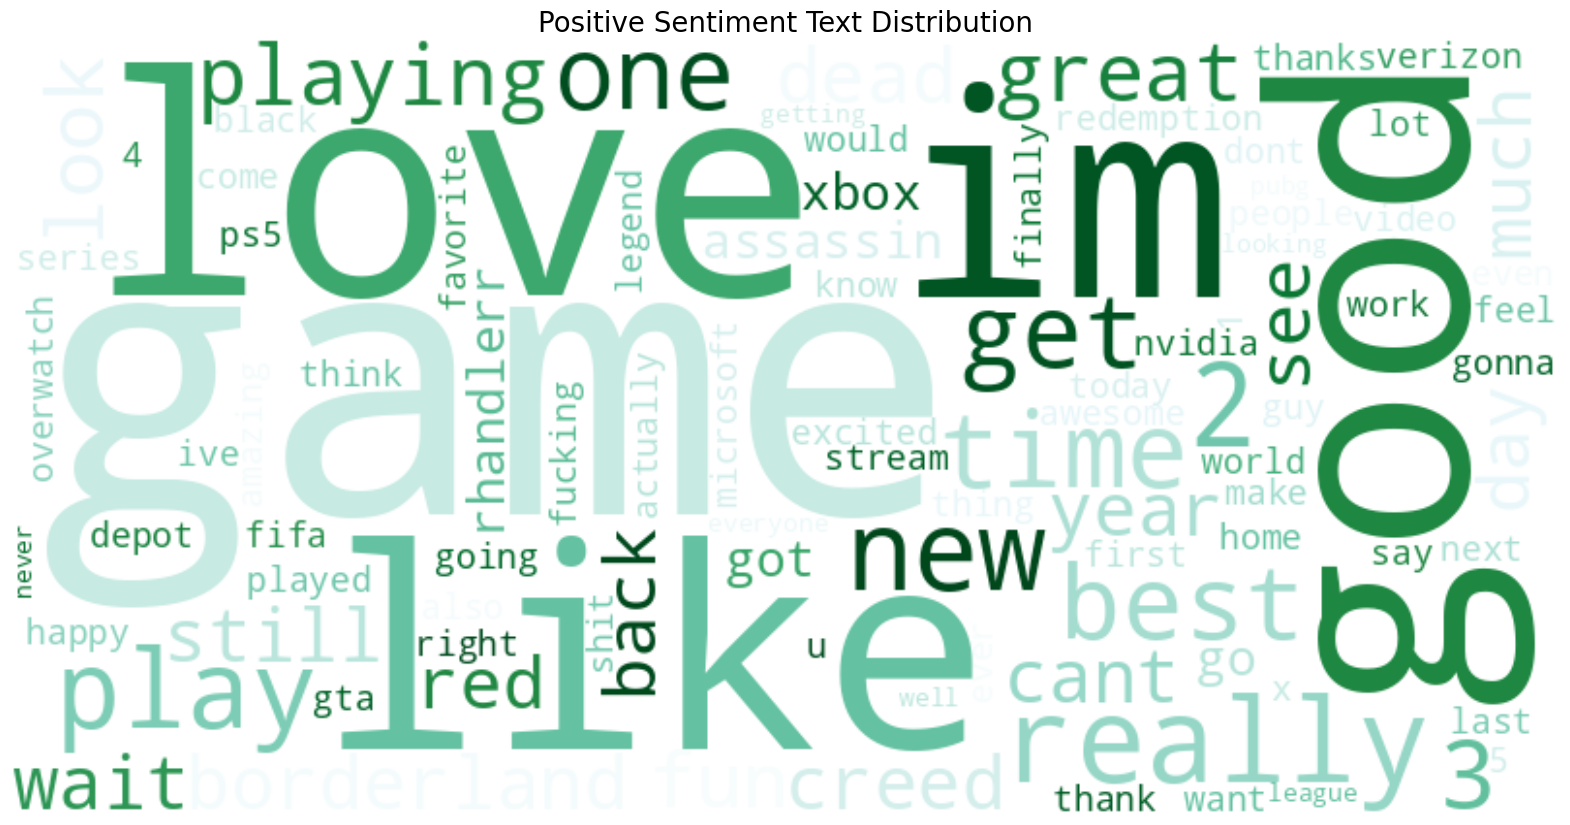

In [ ]:
positive_words = word_seperation(df.loc[df['Sentiment'] == 'Positive']['Content'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

#### Negative Text Sentiment Distribution

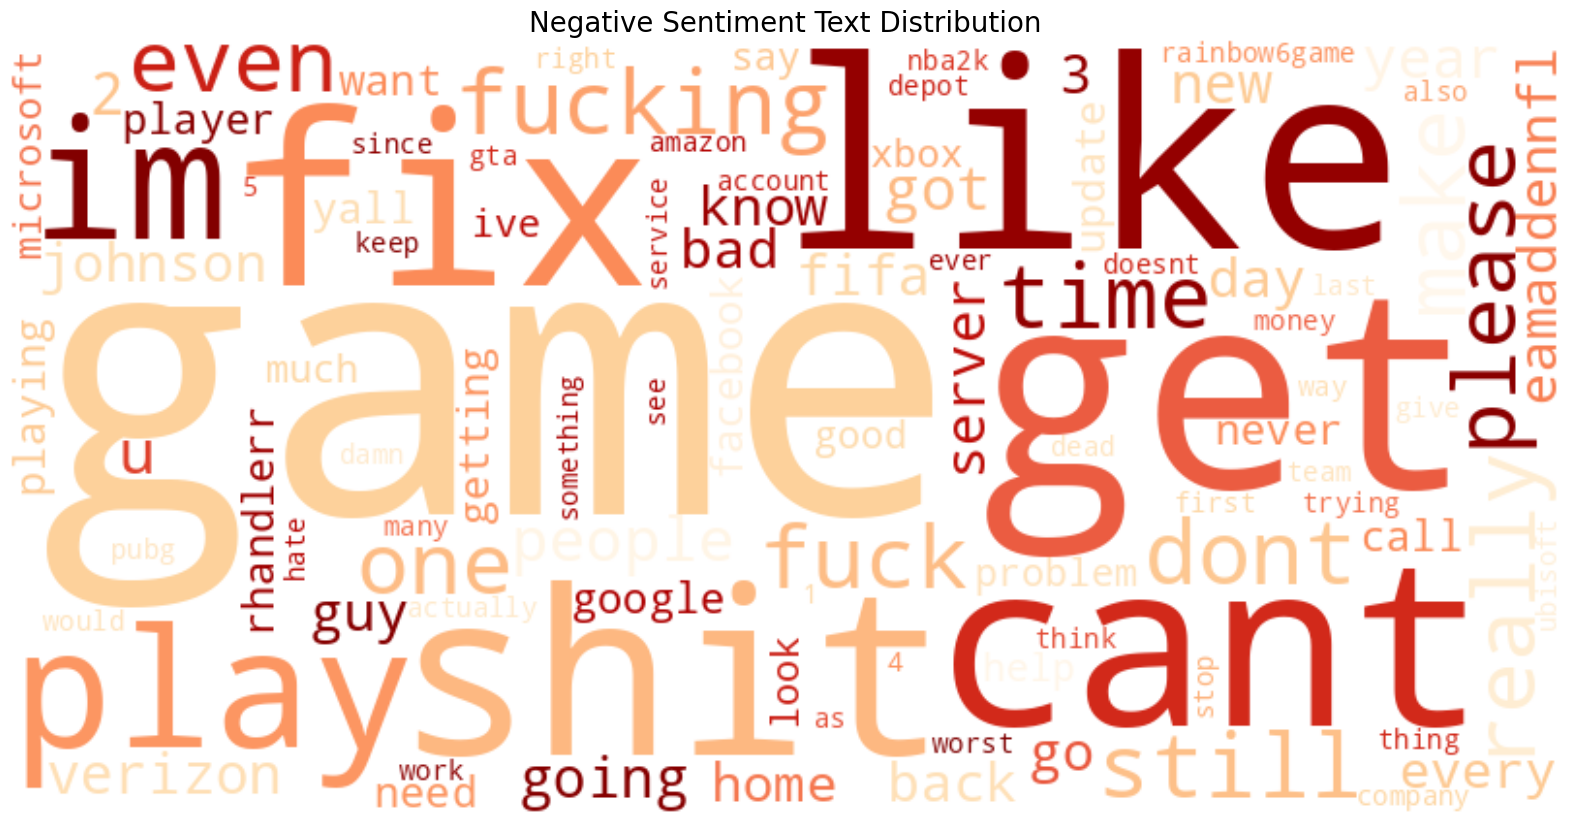

In [ ]:
negative_words = word_seperation(df.loc[df['Sentiment'] == 'Negative']['Content'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

#### Neutral Text Sentiment Distribution

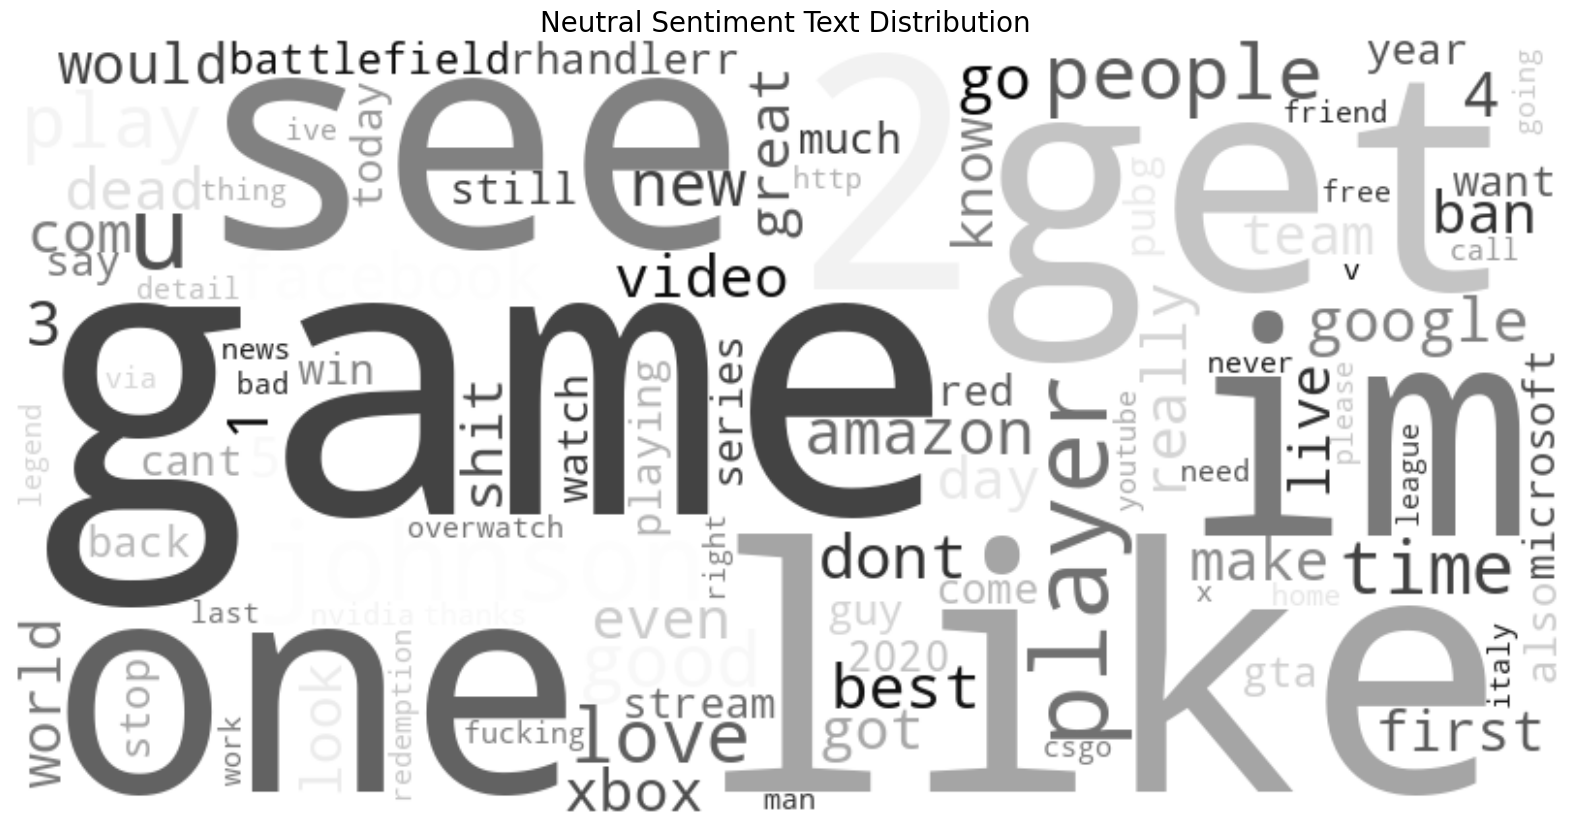

In [ ]:
neutral_words = word_seperation(df.loc[df['Sentiment'] == 'Neutral']['Content'])
neutral_words_df = create_freq_df(neutral_words)
top10_neutral_words = neutral_words_df[:10]

plot_text_distribution(top10_neutral_words['Term'], top10_neutral_words['Frequency'],
                  'Greys', 'Top 10 Neutral Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(neutral_words_df, 'Neutral Sentiment Text Distribution', 'binary_r')

### Preprocess Train Set

In [ ]:
import time
t = time.time()

# Storing data in lists.
text, sentiment = list(df['Content']), list(df['Sentiment'])

processed_text = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 9 seconds


## Model Training

### Splitting data

The Preprocessed Data is divided into 2 sets of data:
*   Training Data: The dataset upon which the model would be trained on. Contains 80% data.
*   Test Data: The dataset upon which the model would be tested against. Contains 20% data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


### TF-IDF Vectorizer

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

Parameters:
*   **ngram_range** : the range of number of words in a sequence.
*   **max_features** : enables using only the ‘n’ most frequent words as features instead of all the words. An integer can be passed for this parameter.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted.')

Vectorizer fitted.


#### Tranforming the dataset
Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


### Creating and Evaluating Models

#### Evaluation Function Definition

In [ ]:
def model_evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))

  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Neutral','Positive']
  values = [value for value in cf_matrix.flatten()]

  labels = [f'{v1}' for v1 in values]
  labels = np.asarray(labels).reshape(3,3)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#### Logistic Regression

              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      4445
     Neutral       0.87      0.92      0.90      6148
    Positive       0.91      0.84      0.87      4207

    accuracy                           0.89     14800
   macro avg       0.89      0.89      0.89     14800
weighted avg       0.89      0.89      0.89     14800



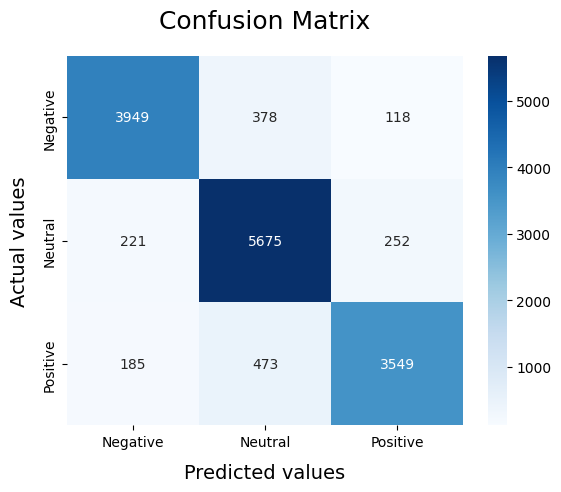

In [ ]:
LR_model = LogisticRegression(multi_class='multinomial', max_iter = 1000)
LR_model.fit(X_train, y_train)
model_evaluate(LR_model)

#### SVM

              precision    recall  f1-score   support

    Negative       0.95      0.92      0.93      4445
     Neutral       0.90      0.95      0.93      6148
    Positive       0.94      0.89      0.91      4207

    accuracy                           0.93     14800
   macro avg       0.93      0.92      0.93     14800
weighted avg       0.93      0.93      0.93     14800



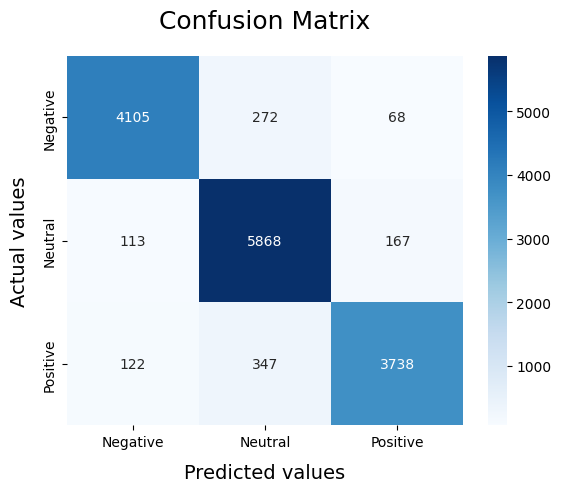

In [ ]:
SVC_model = SVC(decision_function_shape='ovo')
SVC_model.fit(X_train, y_train)
model_evaluate(SVC_model)

#### K-Nearest Neighbor (KNN)

              precision    recall  f1-score   support

    Negative       0.96      0.70      0.81      4445
     Neutral       0.70      0.98      0.81      6148
    Positive       0.97      0.69      0.80      4207

    accuracy                           0.81     14800
   macro avg       0.87      0.79      0.81     14800
weighted avg       0.85      0.81      0.81     14800



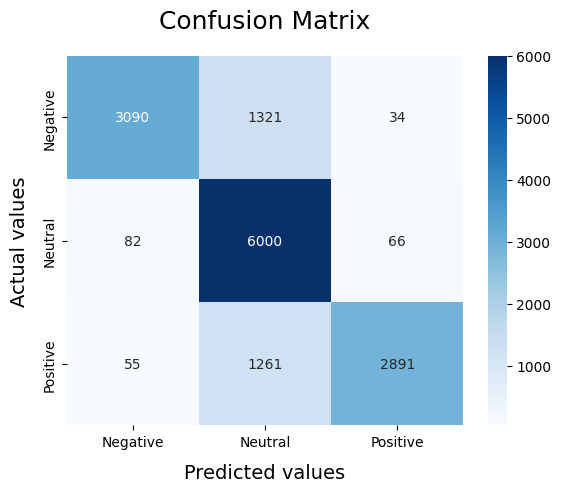

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(X_train, y_train)
model_evaluate(KNN_model)